In [1]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint


In [2]:
# Rossler System
def Rossler(xi, t):
    a = 0.2
    b = 0.2
    c = 5.7
    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def RosslerP(xi, t, a, b, c):    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def Lorenz(xi,t):
    rho = 25.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def LorenzP(xi,t, rho, sigma, beta):
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def Lorenz96(x, t):
    N = 5 # dimension
    F = 8

    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d    

def LorenzYang(xi, t):
    k1 = lambda t : -0.01*(t**2)
    k2 = lambda t : 0.01*t
    k3 = lambda t : 0.01*t
    k4 = lambda t : -0.01*(t ** 2)

    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return -sigma*(x-y)+k1(t)*y, rho*x-y-x*z+k2(t)*z, -beta*z+x*y+(k3(t)+k4(t))*y  # Derivatives

In [3]:
def delayEmbed(Xin, Yin,assignment,embInterval):
    
    tmplen = Xin.shape[1]

    tmp = np.zeros([sum(x) for x in zip(Xin.shape,(0,sum(assignment)))])
    tmp[:,:Xin.shape[1]] = Xin
    Xin = tmp

    lag = 1
    newColInd = 0
    if len(assignment) != tmplen:
        print("Assigment list doesn't match the number of variables in data array! ",assignment)
        return
    else:
        # code that creates the lags
        for i in range(len(assignment)):
            for _ in range(assignment[i]):
                newCol = Xin[:-embInterval*lag,i]
                Xin[embInterval*lag:, tmplen + newColInd] = newCol
                newColInd += 1
                lag += 1
    Xin = Xin[embInterval*sum(assignment):]
    Yin = Yin[embInterval*sum(assignment):]
    
    # Yin = Yin[-X.shape[0]:]
    
    return (Xin, Yin)

In [4]:
begin = 0
end = 100
step = 0.05
tlen = int((end-begin)/step)
trainToTest = 0.5 # between 0 and 1
t = np.arange(begin, end, step)

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 1
# t0 = np.array([0.5])
t0 = np.ones(dim) * 0.5 # np.array([0,5,15]) * 1 # np.zeros(dim)
t0[0] += 0.1

In [5]:
# STATIONARY SIMULATION VERSION: UPDATE ATTRACTOR YOU WANT HERE
#               \/\/\/\/
# X = odeint(Lorenz,t0,t)

# NON STATIONARY VERSION
"""
# Lorenz
rho = lambda t : 28 + 4 * np.sin( 4 * 2*np.pi * t / (tlen-2))# (2*np.heaviside(t-500, 1)-np.heaviside(t-1000, 1)) # rho = 28.0
# sigma = 10       # sigma = 10.0
sigma = lambda t : 10.0 # np.sin( 4 * 2*np.pi * t / (tlen-2))
beta = lambda t : 8.0 / 3.0  # beta = 8.0 / 3.0

largs = lambda t : (rho(t), sigma(t), beta(t))

states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    # print(largs(i))
    states[i] = odeint(LorenzP,states[i-1],np.array([t[i-1],t[i]]),args=largs(i))[1,:]
X = states
"""
"""
# Rossler
ap = lambda t : 0.2 + 0.05 * np.sin( 4 * 2*np.pi * t / (tlen-2))# (2*np.heaviside(t-500, 1)-np.heaviside(t-1000, 1)) # rho = 28.0
# sigma = 10       # sigma = 10.0
bp = lambda t : 0.2 # np.sin( 4 * 2*np.pi * t / (tlen-2))
cp = lambda t : 5.7 # beta = 8.0 / 3.0

largs = lambda t : (ap(t), bp(t), cp(t))

states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    # print(largs(i))
    states[i] = odeint(RosslerP,states[i-1],np.array([0,step]),args=largs(i))[1,:]
X = states
"""
# END NON STATIONARY

'\n# Rossler\nap = lambda t : 0.2 + 0.05 * np.sin( 4 * 2*np.pi * t / (tlen-2))# (2*np.heaviside(t-500, 1)-np.heaviside(t-1000, 1)) # rho = 28.0\n# sigma = 10       # sigma = 10.0\nbp = lambda t : 0.2 # np.sin( 4 * 2*np.pi * t / (tlen-2))\ncp = lambda t : 5.7 # beta = 8.0 / 3.0\n\nlargs = lambda t : (ap(t), bp(t), cp(t))\n\nstates = np.zeros((tlen,3))\nstates[0] = t0\nfor i in range(1, tlen ):\n    # print(largs(i))\n    states[i] = odeint(RosslerP,states[i-1],np.array([0,step]),args=largs(i))[1,:]\nX = states\n'

In [6]:
# Logistic Map

r = lambda t : 0.6 * np.sin(4*2*np.pi*t/tlen) + 3.4
# r = lambda t : 0.5 * t / tlen + 3.5
states = np.zeros((tlen,1))
states[0,0] = t0
for t in range(1,tlen):
    states[t,0] = r(t) * states[t-1,0] * (1 - states[t-1,0])
X = states
"""

# Density Dependent Maturation
states = np.ones((tlen, 2))
s = 0.02
gamma = 0.01
sA = 0.1
sJ = 0.5
b = 35
# Gmax = 0.9
# g = lambda x : Gmax*np.exp(-gamma*x)
# Gmax = lambda t : 0.25 + t * 0.74 / (tlen-2) # LINEAR GMAX
# Gmax = lambda t : 0.75 + 0.25 * np.sin( 4 * 2 * np.pi * t / (tlen-2)) # PERIODIC
Gmax = lambda t : 0.75
g = lambda x , t: Gmax(t)*np.exp(-gamma*x)
states[0] = np.array([5,300])
for i in range(0,tlen-1):
    At = states[i,0]
    Jt = states[i,1]
    zt = rand.normal(-s/2, s) # rand.normal(0,s) # vs rand.normal(-(s**2)/2, s)
    # m = np.array([[sA, sJ*g(At+Jt)],[b*np.exp(zt), sJ*(1-g(At+Jt))]])
    m = np.array([[sA, sJ*g(At+Jt,i)],[b*np.exp(zt), sJ*(1-g(At+Jt,i))]])
    states[i+1] = m @ states[i].T
X = states
"""

'\n\n# Density Dependent Maturation\nstates = np.ones((tlen, 2))\ns = 0.02\ngamma = 0.01\nsA = 0.1\nsJ = 0.5\nb = 35\n# Gmax = 0.9\n# g = lambda x : Gmax*np.exp(-gamma*x)\n# Gmax = lambda t : 0.25 + t * 0.74 / (tlen-2) # LINEAR GMAX\n# Gmax = lambda t : 0.75 + 0.25 * np.sin( 4 * 2 * np.pi * t / (tlen-2)) # PERIODIC\nGmax = lambda t : 0.75\ng = lambda x , t: Gmax(t)*np.exp(-gamma*x)\nstates[0] = np.array([5,300])\nfor i in range(0,tlen-1):\n    At = states[i,0]\n    Jt = states[i,1]\n    zt = rand.normal(-s/2, s) # rand.normal(0,s) # vs rand.normal(-(s**2)/2, s)\n    # m = np.array([[sA, sJ*g(At+Jt)],[b*np.exp(zt), sJ*(1-g(At+Jt))]])\n    m = np.array([[sA, sJ*g(At+Jt,i)],[b*np.exp(zt), sJ*(1-g(At+Jt,i))]])\n    states[i+1] = m @ states[i].T\nX = states\n'

In [7]:
# Read input data from files
"""
file = "paramecium_didinium - cleaned.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
X = data.to_numpy()
print(X)
"""

'\nfile = "paramecium_didinium - cleaned.csv"\ndata = pd.read_csv(file,encoding="utf-8",na_filter=False)\nX = data.to_numpy()\nprint(X)\n'

In [8]:
X, _ = delayEmbed(X, X, [5],1)

In [9]:
# X = (X - X.mean(0) ) / X.std(0) # normalize
print(X)

[[0.83972486 0.42431121 0.85538626 0.50883678 0.81780951 0.6       ]
 [0.46367868 0.83972486 0.42431121 0.85538626 0.50883678 0.81780951]
 [0.85862273 0.46367868 0.83972486 0.42431121 0.85538626 0.50883678]
 ...
 [0.70429445 0.7036359  0.70297015 0.70230523 0.70163543 0.70096511]
 [0.70495663 0.70429445 0.7036359  0.70297015 0.70230523 0.70163543]
 [0.70560726 0.70495663 0.70429445 0.7036359  0.70297015 0.70230523]]


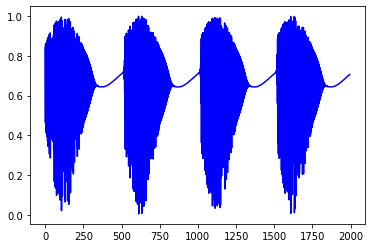

In [11]:
fig2 = plt.figure(2)
if dim == 1:
    ax2 = plt.subplot()
    ax2.plot(X[:,0],"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(X[:,0],X[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(X[:,0],X[:,1],X[:,2])
    

if dim != 1:
    figTS, axTS = plt.subplots(dim,figsize=(6,dim*1.5))
    for i in range(dim):
        axTS[i].plot(X[:,i])

plt.show()

1995


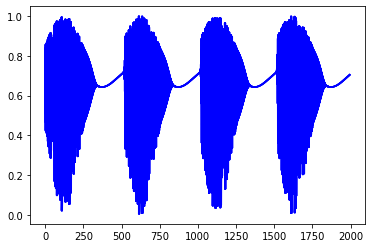

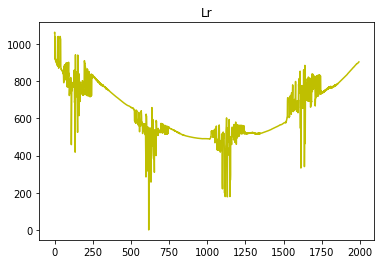

In [12]:
def lr(X,r):
    # increase the border e depending on one std distance in given dimension
    global dim 
    e = 0.5 * ((dim) ** 0.5)
    
    ind = e > la.norm(X - X[r],axis=1)
    
    neighbors = X[ind]
    neighborIndexes = np.arange(0,X.shape[0],1)[ind]
    
    l_r = np.sum(np.absolute(neighborIndexes - r)) / neighborIndexes.shape[0]
    
    return l_r
print(X.shape[0])
LR = np.zeros((X.shape[0]))
for i in range(X.shape[0]):
    LR[i] = lr(X,i)
# print(LR)

fig3 = plt.figure(3)
if dim == 1:
    ax3 = plt.subplot()
    ax3.plot(X,"b") # states
elif dim == 2:
    ax3 = plt.subplot()
    ax3.plot(X[:,0],X[:,1])
else:
    ax3 = fig2.gca(projection="3d")
    ax3.plot(X[:,0],X[:,1],X[:,2])
    
# ax3 = fig3.add_subplot(projection="3d")
# ax3.scatter(X[:,0],X[:,1],X[:,2],c="b",alpha=0.5)
lrfig = plt.figure(4)
axlr = lrfig.add_subplot(title="Lr")
axlr.plot(LR,c="y")

plt.show()

605.4053571428572


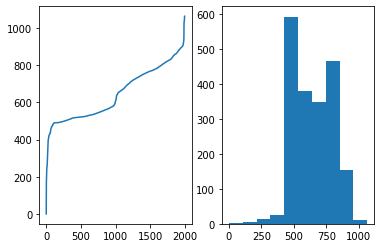

In [13]:
LRsort = sorted(LR)

fig4, axLRsorted = plt.subplots(1,2)
axLRsorted[0].plot(LRsort)
axLRsorted[1].hist(LRsort)

print(np.median(LR))

plt.show()

In [14]:
def U(x, xj, k):
    return sorted(range(len(x)-1), key = lambda i : la.norm(xj - x[i]), reverse=False)[1:k+1]

[1, 2, 18, 3, 17] [19 36 36 51 51]


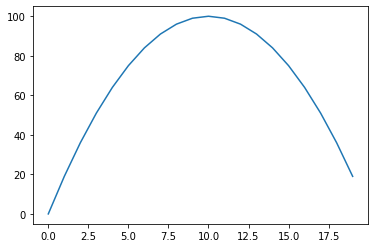

In [15]:
# U testing
test = 100 - (np.arange(0,20,1)-10) ** 2
print(U(test,0,5), test[U(test,0,5)])

plt.plot(test)
plt.show()

In [16]:
# conditional distance
def dc(x, j, t, k):
    u = U(x, x[j], k)
    
    # print(u)
    
    D = 0
    K = k
    for l in u:
        if j+t < x.shape[0] and l+t < x.shape[0]:
            D += la.norm(x[j+t] - x[l+t])
        else:
            print("cannot access element")
            k -= 1
    
    return D / K

# neighbor distance
def d(x, j, k):
    u = U(x, x[j], k)
    
    D = 0
    for l in u:
        D += la.norm(x[j] - x[l])
    
    return D / k

In [17]:
# distance tests
print(test[U(test,test[0],5)])
print(d(test, 0, 5))
print(dc(test, 0, 2, 5))

unif = np.ones(50)
print(d(unif, 4, 10))
print(dc(unif, 4, 5, 10))

[19 36 36 51 51]
38.6
cannot access element
19.8
0.0
0.0


In [18]:
# dynamic similarity
def S(x, j, t, k):
    return d(x, j, k) / dc(x, j, t, k)

cannot access element


C:\Users\Kenneth\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Kenneth\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


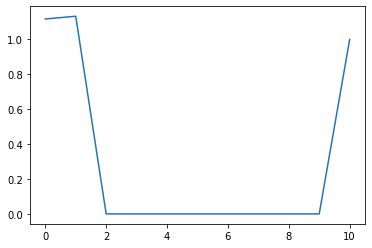

In [19]:
s = np.zeros(test.shape[0])
for i in range(len(s)):
    s[i] = S(test, i, 1, 1)
    
plt.plot(s)
plt.show()

In [20]:
def flus(x, k, low, upp):
    s = np.zeros(upp-low)
    for i in range(low,upp):
        s[i-low] = S(x, i, 1, k)
    
    mus = sum(s) / (upp - low)
    
    fl = sum( (s-mus)**2 )
    return fl

In [21]:
print(flus(X, 5, 0, 19))
winSize = 100
"""
FlucOfSim = np.zeros(tlen - winSize)
for i in range(FlucOfSim.shape[0]):
    FlucOfSim[i] = flus(X, 20, i, i+winSize)
    print(FlucOfSim[i])
"""

0.40238982304182214


'\nFlucOfSim = np.zeros(tlen - winSize)\nfor i in range(FlucOfSim.shape[0]):\n    FlucOfSim[i] = flus(X, 20, i, i+winSize)\n    print(FlucOfSim[i])\n'

In [22]:
"""
fig, axs = plt.subplots(2,1)

axs[0].plot(X)
axs[1].plot(FlucOfSim)
plt.show()
"""

'\nfig, axs = plt.subplots(2,1)\n\naxs[0].plot(X)\naxs[1].plot(FlucOfSim)\nplt.show()\n'

In [23]:
# Slow Feature Analysis

def hprime(x):
    n = x.shape[0]
    d = x.shape[1]
    
    M = int(d+d*(d+1)/2) # number of monomials and binomials
    
    hx = np.zeros((n,M))
    hx[:,0:d] = x
    ind = d
    for i in range(d):
        xi = x[:,i]
        for j in range(i,d):
            xj = x[:,j]
            hx[:,ind] = np.multiply(xi, xj)
            ind += 1
            
    return hx

def standardize(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

In [24]:
np.set_printoptions(precision=4, suppress=True)
# print("X = ", X.shape)
Xst = standardize(X)
# print(Xst.shape, hp.shape)
# zprime = Xst
zprime = hprime(Xst)
c = np.cov(zprime.T, bias=False)
print("Covariance = ", c, c.shape)

eigval, eigvec = la.eig(c)
# print("Eigenstuff = ", eigval, eigvec)

diagEigVal = np.diag(eigval ** -0.5) #  

print(zprime.shape, diagEigVal.shape, eigvec.T.shape)
z = zprime @ (eigvec @ diagEigVal)
# z = np.real(z)
print("z = ", z)
print("Mean test(should be 0)", np.mean(z))
print("Covariance test(should be I): \n",np.cov(z.T))

Covariance =  [[ 1.0005 -0.4131  0.2043 -0.0556  0.1898 -0.1635 -0.8927  0.1939 -0.257
  -0.2779 -0.0975 -0.2494 -0.8261  0.3516  0.0613 -0.0088  0.0435  0.2035
  -0.1572  0.1391  0.0859 -0.2991  0.0455 -0.1379 -0.239   0.08   -0.1305]
 [-0.4131  1.0005 -0.4135  0.2045 -0.0561  0.1898  0.1939 -0.8261  0.3516
   0.0613 -0.0088  0.0435 -0.8905  0.1934 -0.2565 -0.2775 -0.0971 -0.8251
   0.3511  0.061  -0.009   0.2041 -0.1572  0.1393 -0.2987  0.0452 -0.2382]
 [ 0.2043 -0.4135  1.0005 -0.4138  0.2049 -0.0563 -0.257   0.3516  0.2035
  -0.1572  0.1391  0.0859  0.1934 -0.8251  0.3511  0.061  -0.009  -0.8902
   0.1937 -0.2562 -0.2772 -0.8253  0.351   0.0608  0.2039 -0.157  -0.299 ]
 [-0.0556  0.2045 -0.4138  1.0005 -0.414   0.2049 -0.2779  0.0613 -0.1572
  -0.2991  0.0455 -0.1379 -0.2565  0.3511  0.2041 -0.1572  0.1393  0.1937
  -0.8253  0.351   0.0608 -0.8887  0.1931 -0.2558 -0.8245  0.3506  0.2044]
 [ 0.1898 -0.0561  0.2049 -0.414   1.0005 -0.4141 -0.0975 -0.0088  0.1391
   0.0455 -0.239   0.

In [25]:
zdot = z[1:,:] - z[:-1,:]

# print((zdot @ zdot.T).round(4))
eigValDot, eigVecDot = la.eig(zdot.T @ zdot)
print("EigenVectors = ", eigVecDot)
print(eigValDot)

a = eigVecDot[:,np.argsort(eigValDot)[0]] # eigVecDot.sort(key=eigValDot)[0]
print(a)
yt = a @ z.T
print(a.shape, z.shape)

EigenVectors =  [[ 0.7534  0.6167 -0.1427 -0.0768  0.0236  0.0664 -0.0169  0.004   0.0132
  -0.0075  0.0327 -0.1084  0.0326  0.0002  0.0041 -0.0168  0.0121  0.0228
  -0.0027 -0.0517 -0.0269  0.012   0.0236 -0.0147 -0.0304  0.0171 -0.0004]
 [ 0.0216  0.01    0.0281  0.096  -0.0222 -0.1006  0.0493 -0.1073 -0.027
  -0.0059  0.0386 -0.167   0.0418 -0.083   0.037   0.1492 -0.4153  0.1117
  -0.1793  0.0365 -0.1274 -0.0219 -0.4505  0.3112 -0.1489 -0.5484 -0.2114]
 [-0.0041  0.1024 -0.1066 -0.1202  0.0146  0.0552  0.0465  0.0078  0.0732
  -0.0145  0.2126  0.3827 -0.113  -0.0894  0.1758 -0.0927  0.0718  0.0324
   0.0611  0.6943  0.3642 -0.2029 -0.0778  0.0915  0.0218 -0.1406  0.0158]
 [-0.2986  0.1442 -0.4798 -0.5564  0.0241  0.3636 -0.1075  0.2259  0.0301
   0.0248 -0.1022  0.0548 -0.1723  0.0207 -0.0569  0.077  -0.1285  0.1657
  -0.0707 -0.1509 -0.1119  0.0478  0.0113 -0.0174 -0.0351 -0.1029 -0.0415]
 [-0.022  -0.0856 -0.0105 -0.0738 -0.0579  0.1231 -0.4494  0.0525 -0.0765
  -0.112   0.4747 -

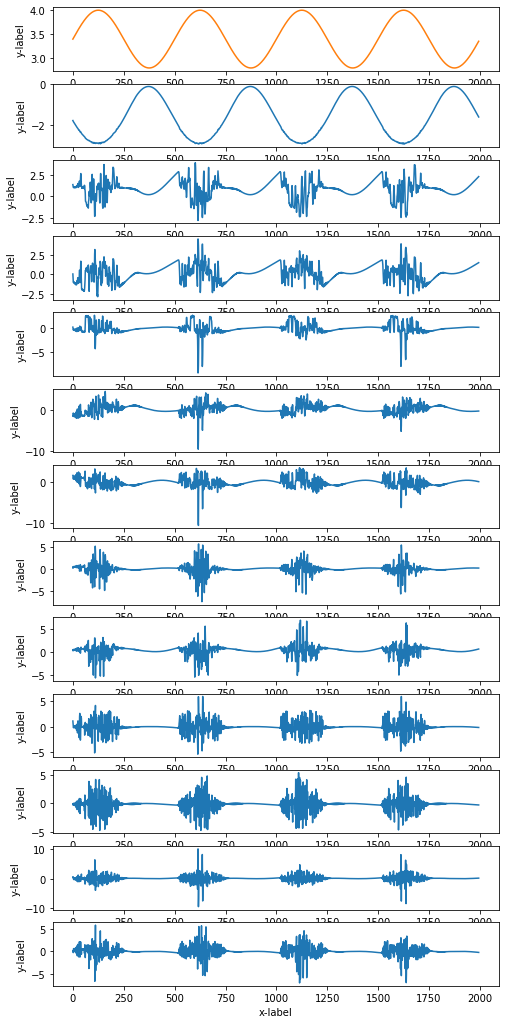

In [27]:
# gts = np.fromfunction(lambda i : r(i), yt.shape, dtype = float)# time series of gmax

# gts = np.fromfunction(lambda i : Gmax(i), yt.shape, dtype = float)# time series of gmax
gts = np.fromfunction(lambda i : r(i), yt.shape, dtype = float)# time series of gmax

E = 12 #len(eigValDot)
fig, axs = plt.subplots(E+1,figsize=(8,E*1.5))
axs[0].plot(gts, c="tab:orange")

# print(ae.shape, z.T.shape)
for e in range(E):
    ae = eigVecDot[:,np.argsort(eigValDot)[e]]
    axs[e+1].plot(ae @ z.T)

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')


# plt.plot(yt)

plt.show()